## Importing the Important Libraries

In [1]:
import os 
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from collections import deque, namedtuple
import gymnasium as gym
from gymnasium.wrappers import RecordVideo 
import matplotlib.pyplot as plt        
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Environment Setups

In [2]:
base_env = gym.make("LunarLander-v3", 
                    continuous=False, 
                    gravity=-10.0,
                    enable_wind=False, 
                    wind_power=15.0, 
                    turbulence_power=1.5,
                    render_mode="rgb_array")


env = RecordVideo(base_env, video_folder='./video_training', episode_trigger=lambda x: x % 25 == 0)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("State Size:", state_size, "| Action Size:", action_size)

State Size: 8 | Action Size: 4


## Defining the Hyperparameter for the agent

In [3]:
learning_rate = 5e-4
minibatch = 150
gamma = 0.99
replay_buffer_size = 100000
interpolation_parameter = 1e-3
number_episodes = 5000
max_time_steps = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
scores_100_episodes = deque(maxlen=100)

## Defining the Neural Networks

In [4]:
class ANN(nn.Module):
        def __init__(self, state_size, action_size, seed =42):
                super(ANN, self).__init__()
                self.seed = torch.manual_seed(seed)
                self.fc1 = nn.Linear(state_size, 64)
                self.fc2 = nn.Linear(64, 64)
                self.fc3 = nn.Linear(64, action_size)

        def forward(self, state):
                x = self.fc1(state)
                x = F.relu(x)
                x = self.fc2(x)
                x = F.relu(x)
                return self.fc3(x)

## ReplayMemory: 
- The ReplayMemory class is designed to manage the agent's memory of game experiences. It stores the state, action, reward, next state, and whether the episode ended(done) for each step in the game.

         experience = (state, action, reward, next_state, done)

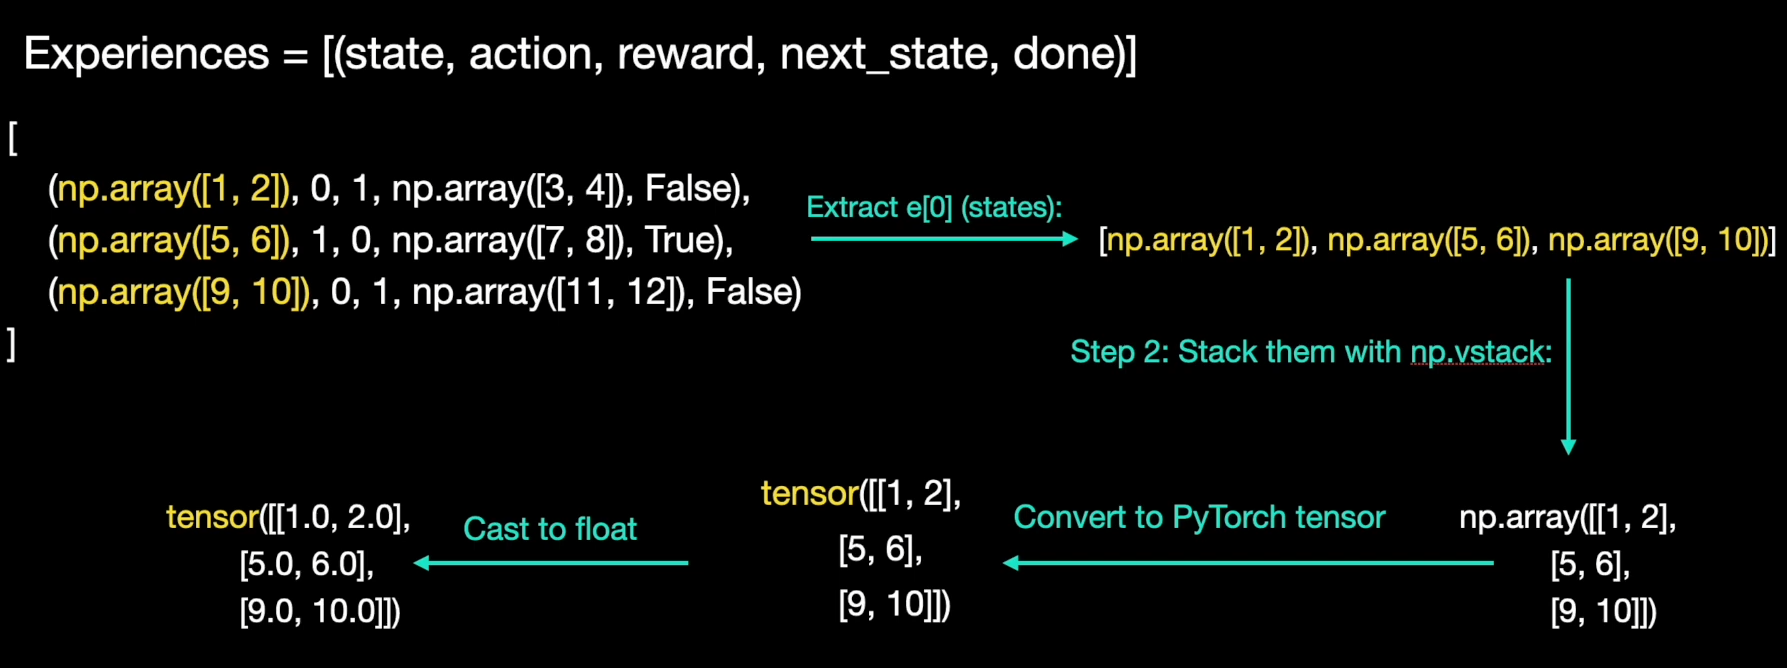

In [5]:
class ReplayMemory(object):

        def __init__(self, capacity):
                self.capacity = capacity
                self.memory = []

        
        def push(self, event):
                self.memory.append(event)
                if len(self.memory) > self.capacity:
                        del self.memory[0]

        
        def sample(self, batch_size):
                experiences = random.sample(self.memory, batch_size)
                states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
                actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
                rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
                next_state = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float()
                dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float()

                return states, actions, rewards, next_state, dones

## Defining the RL Agent

- ## Local Vs Target Q-Network
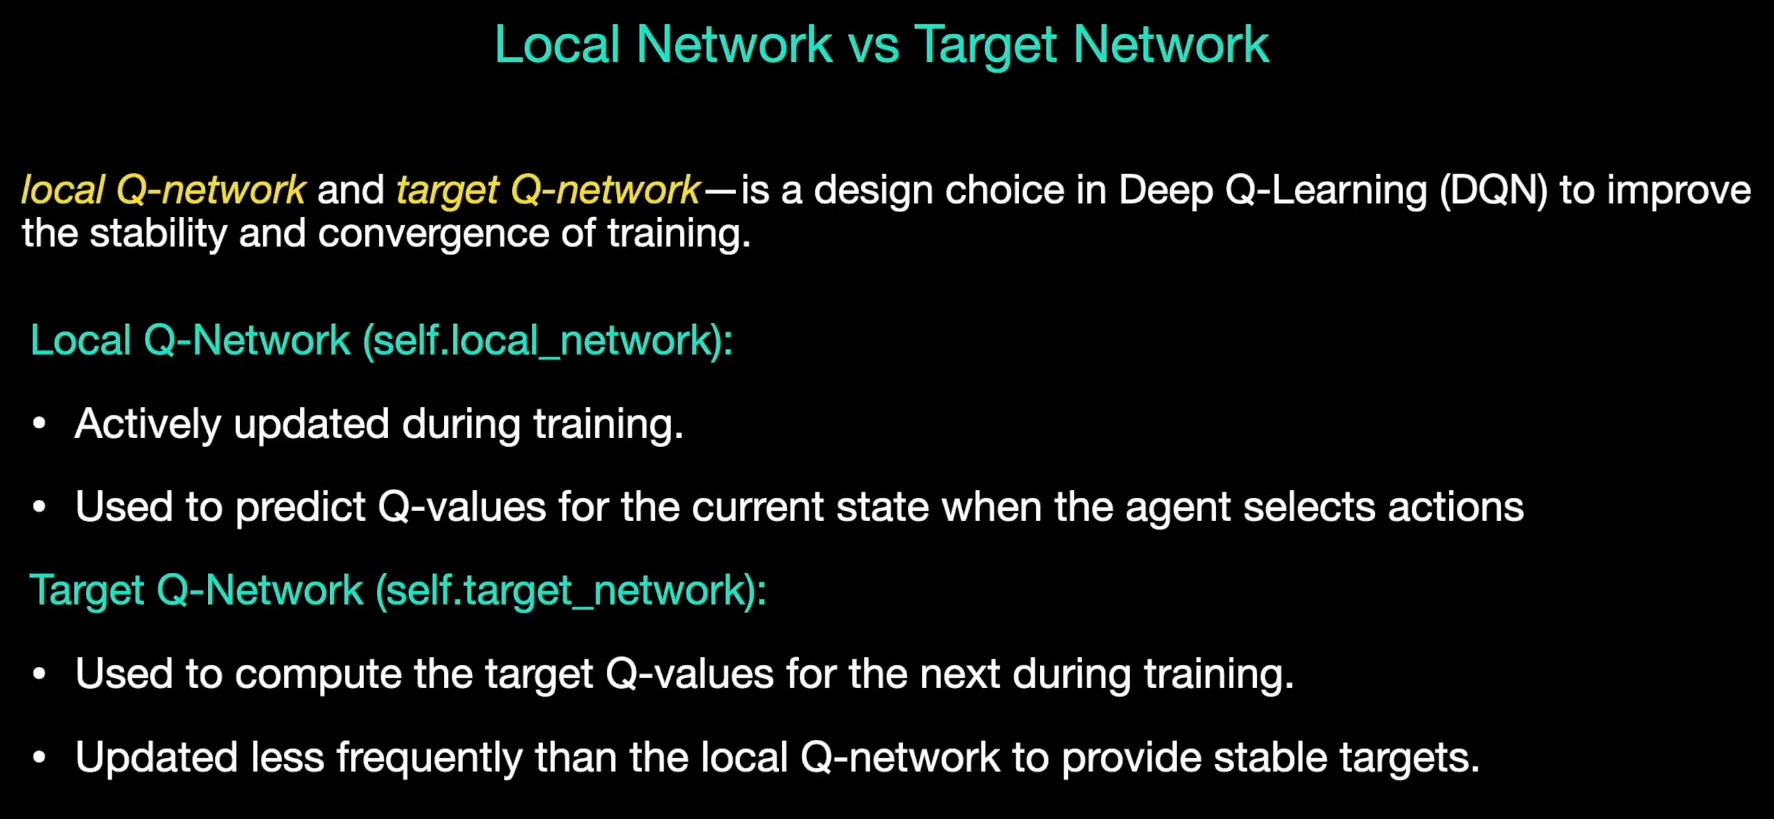

- ## Exploration Vs Exploitation Tradeoffs
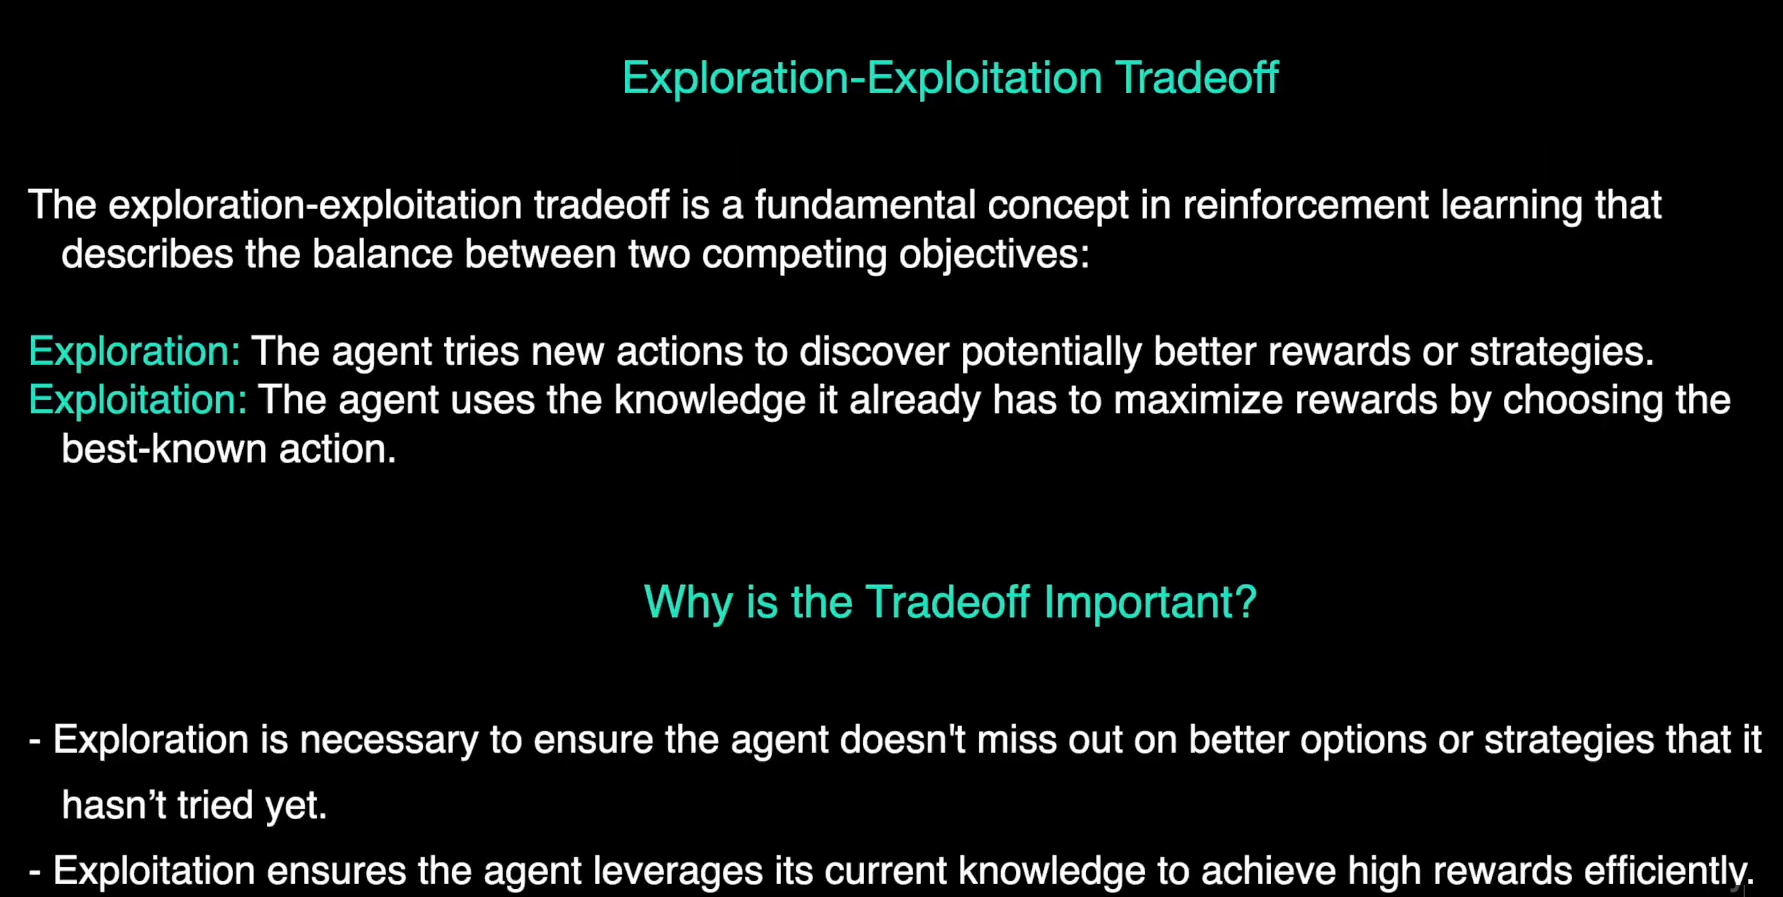

- ## Bellmen Equation
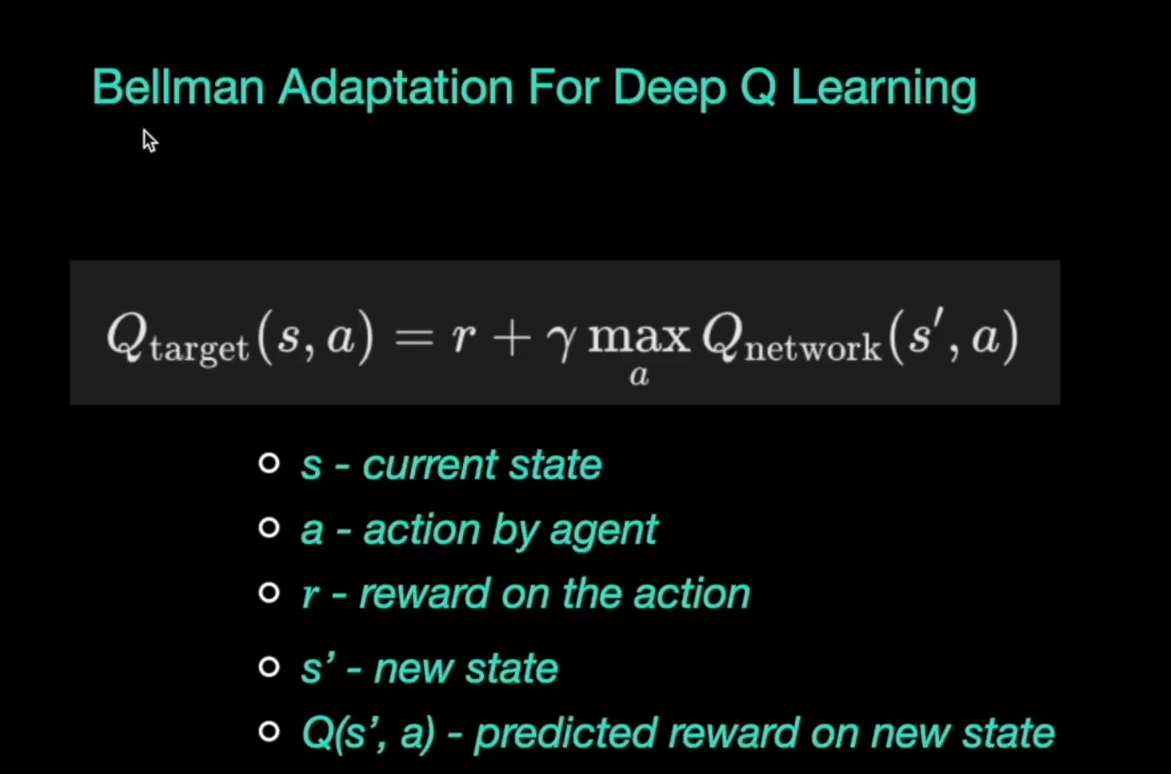

- ## Next-Q-Target State
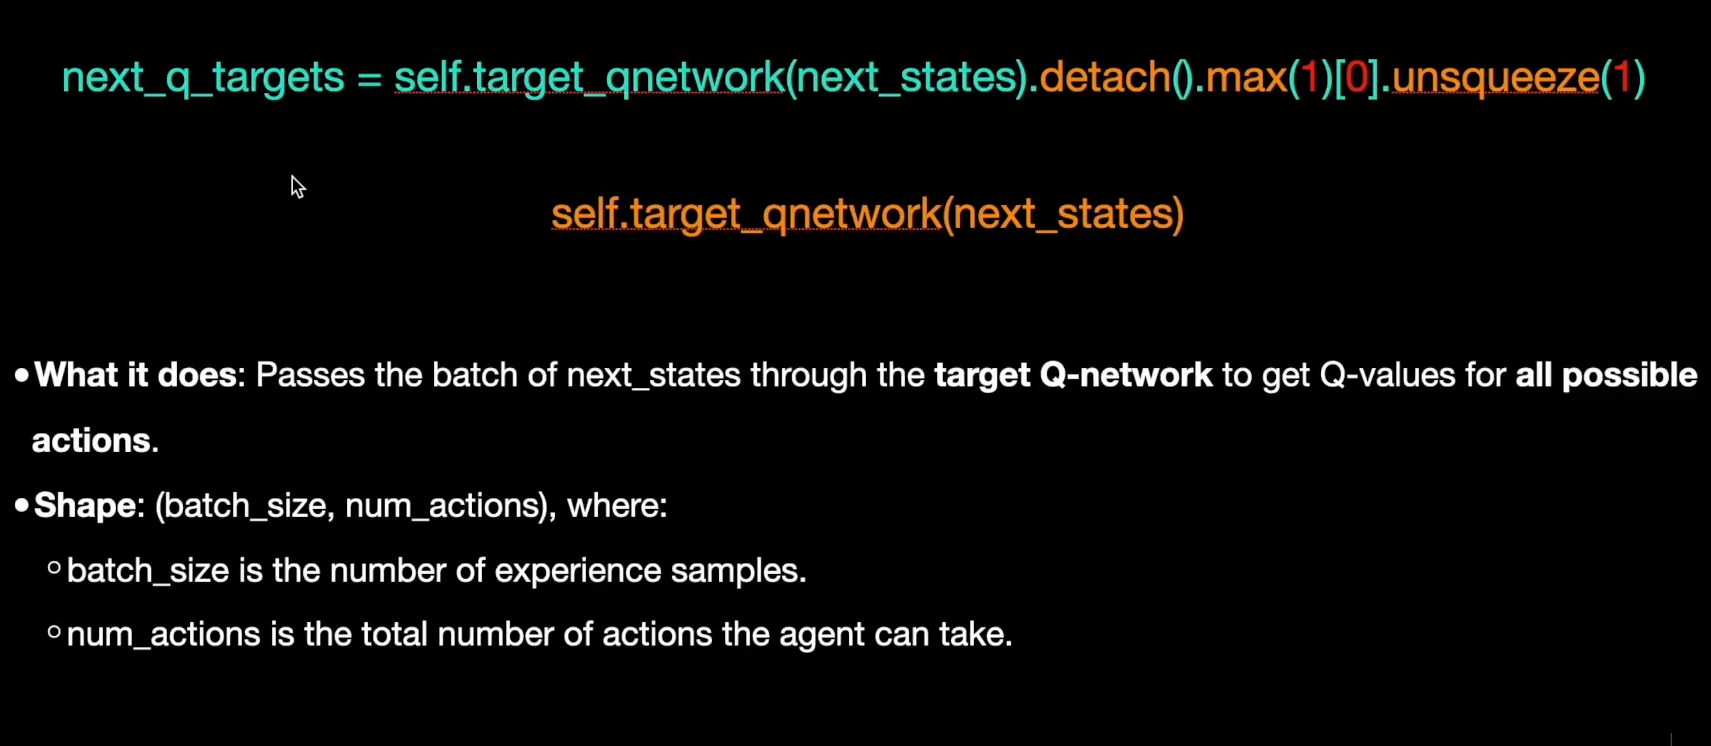

- ## Detach() method.
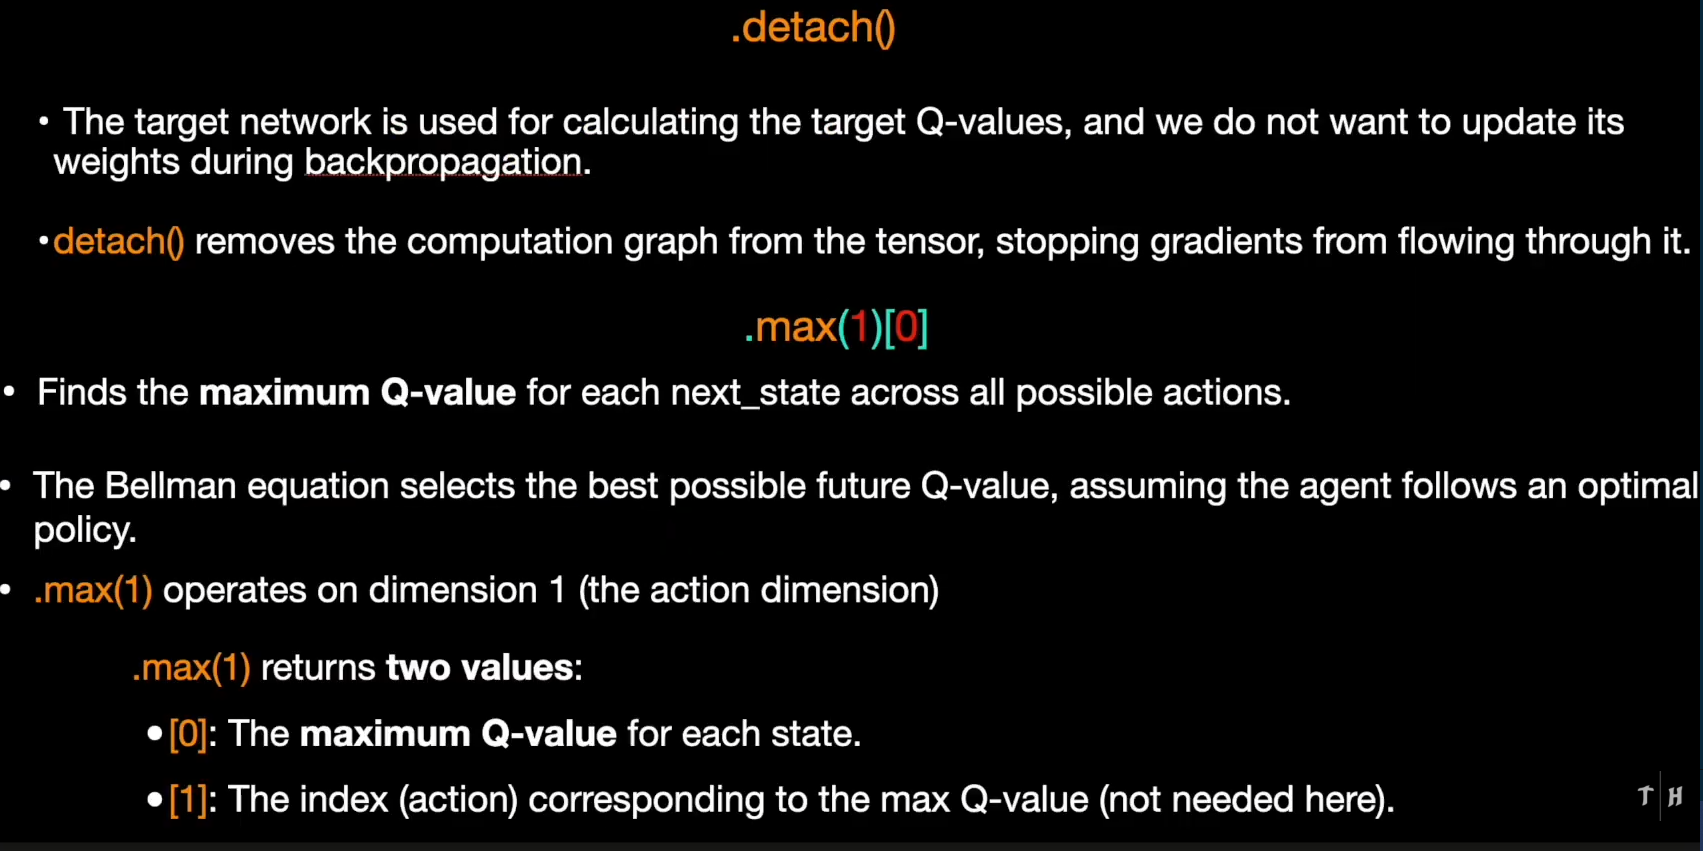

- ## Unsqueeze() method.
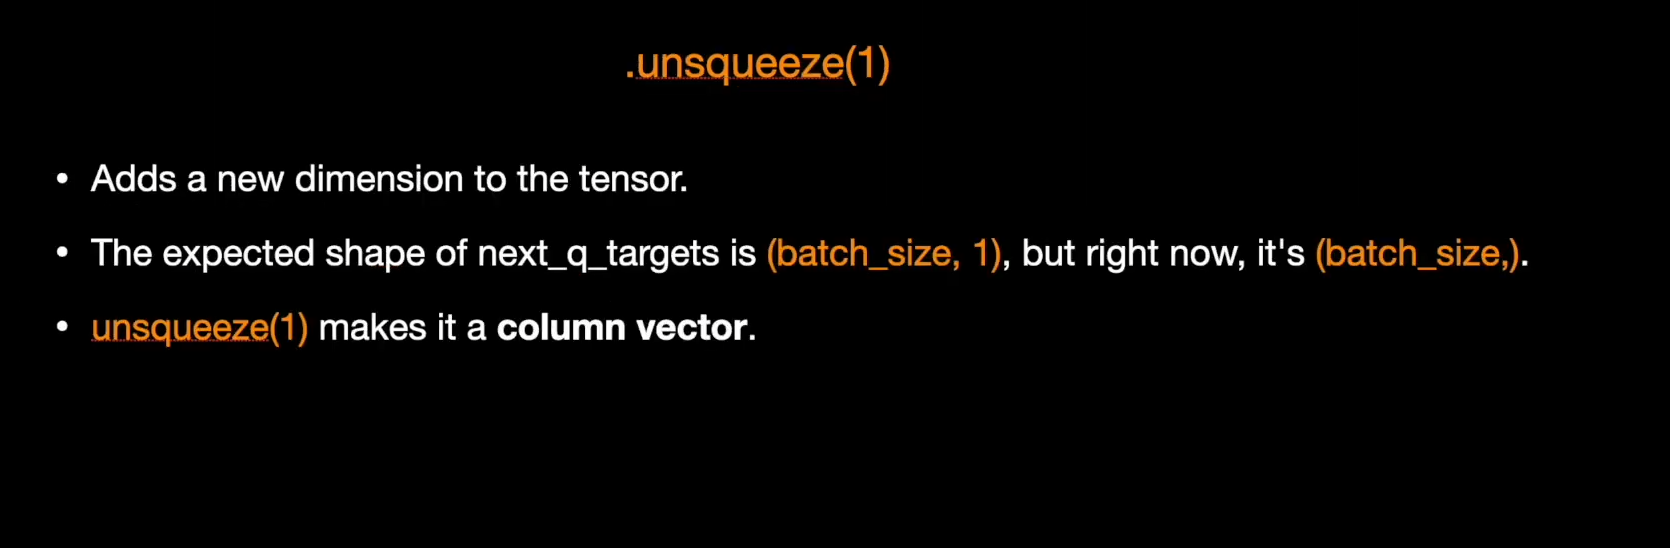

- ## Example for the Next-Q-Targets.
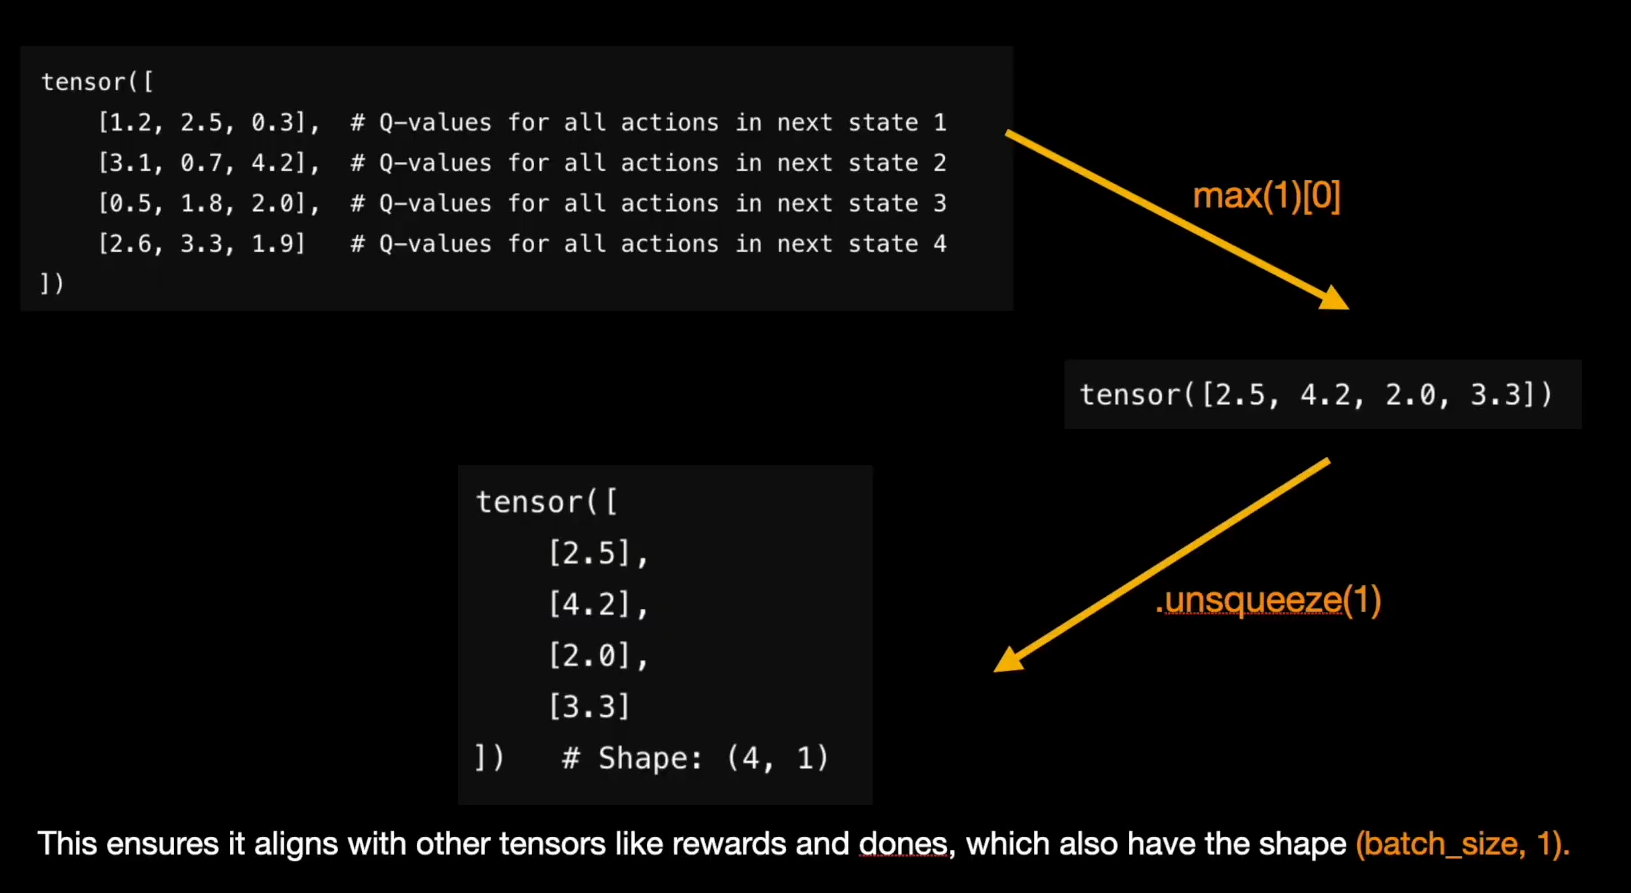

- ## Loss Calculation
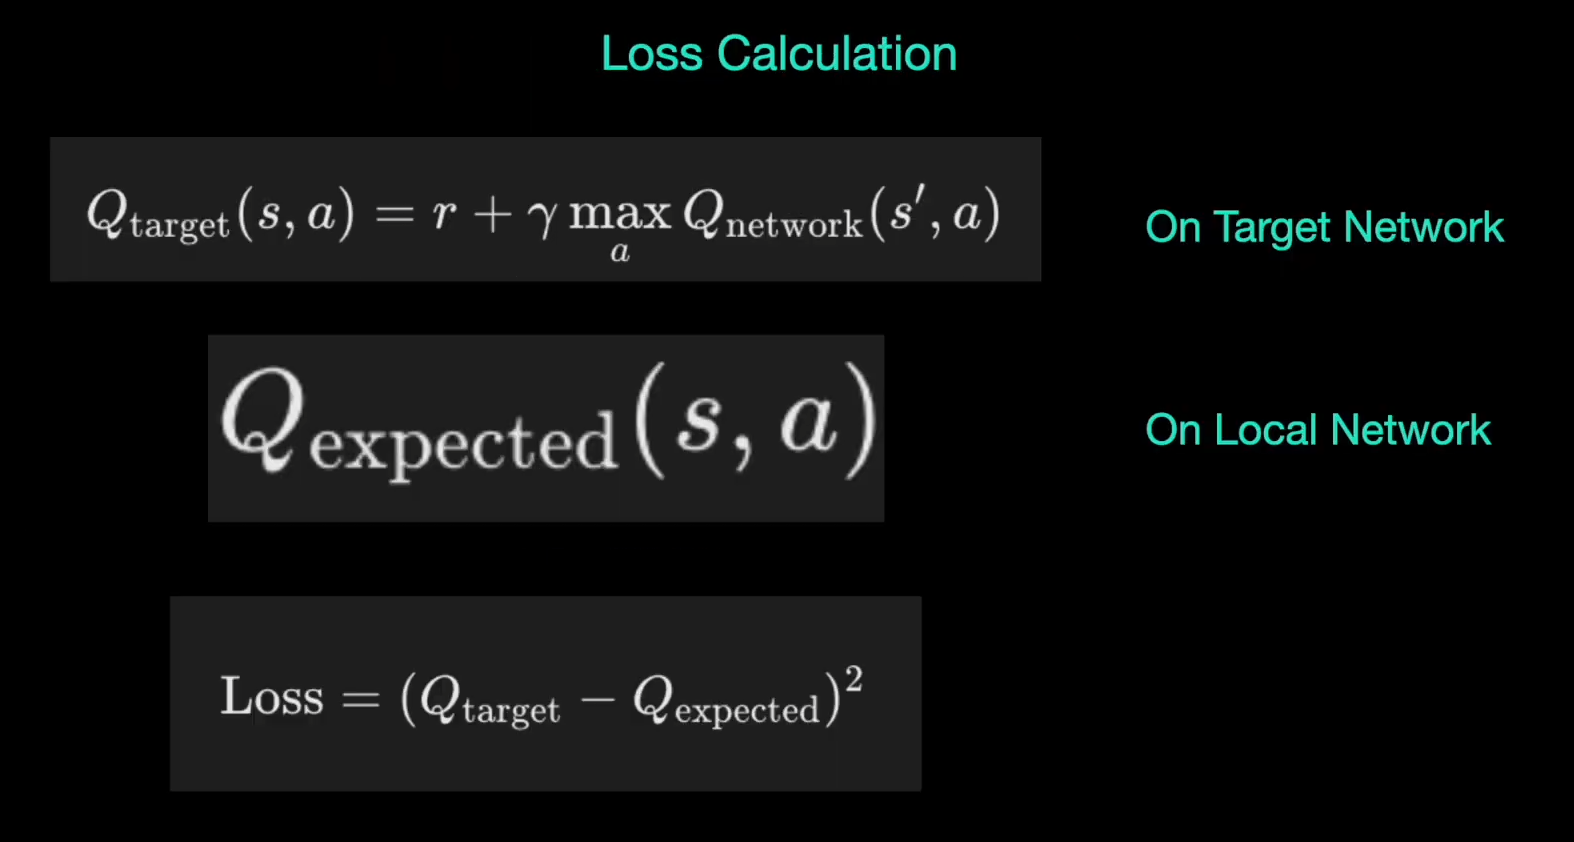

- ## Loss Functions()
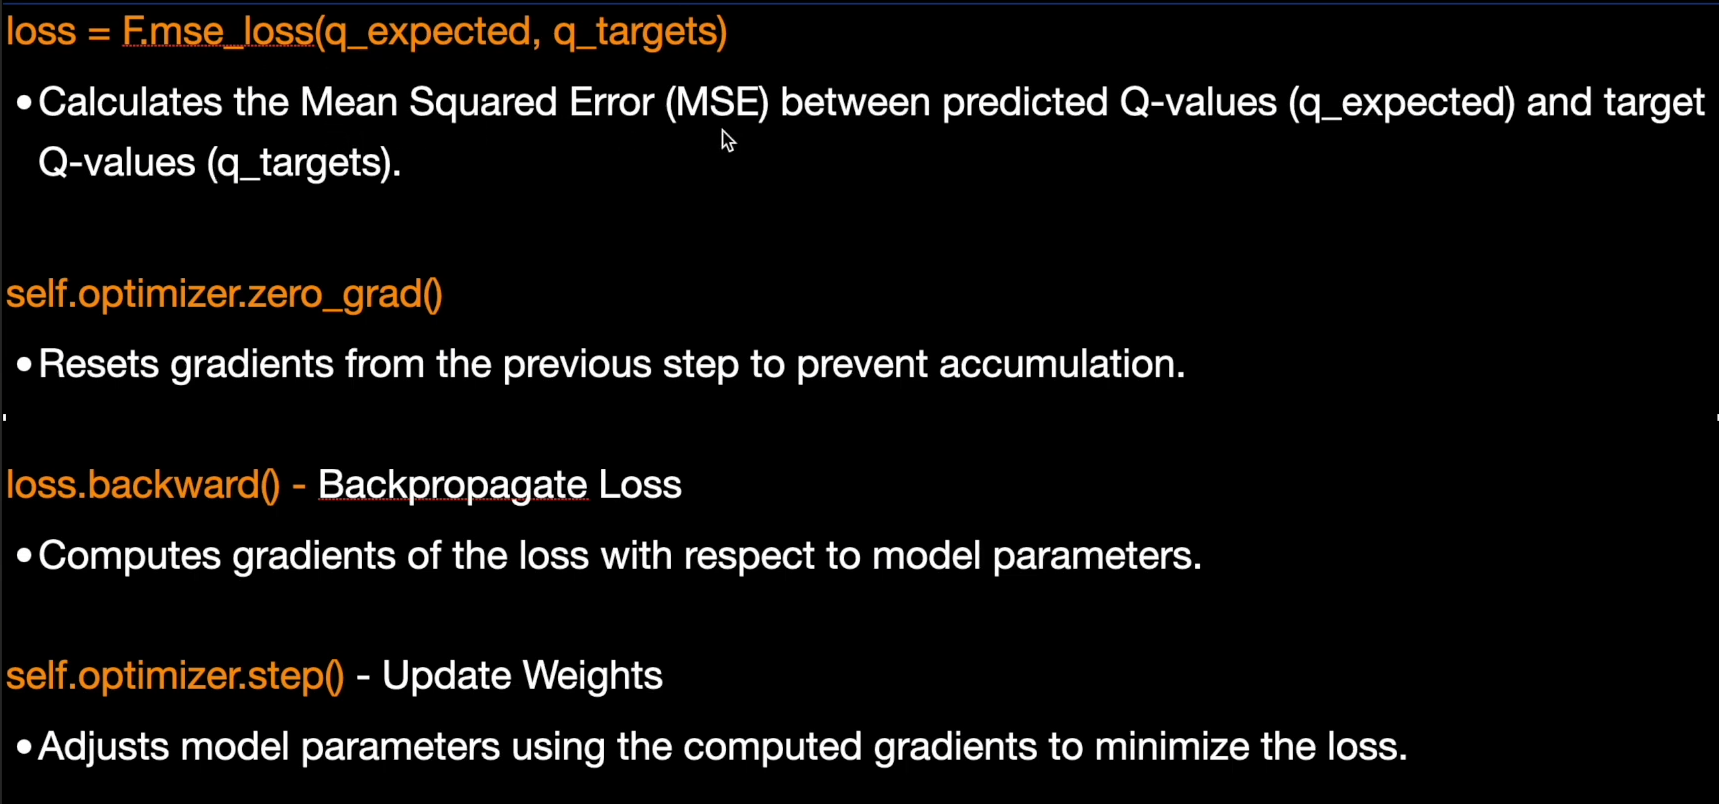

- ## How Soft Update Function Works
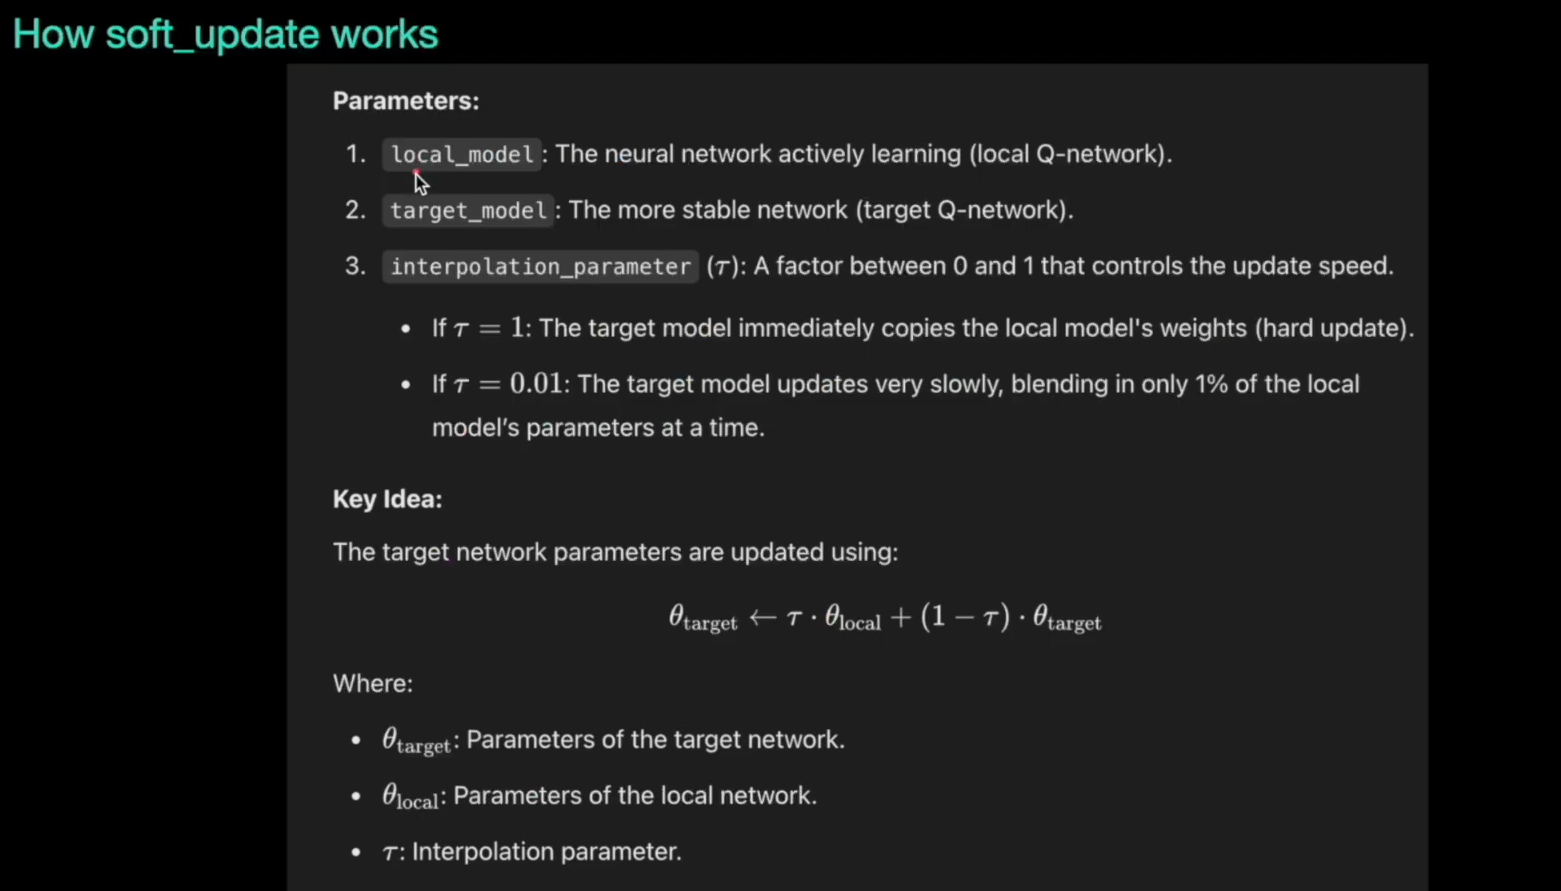

In [6]:
class Agent():

        def __init__(self, state_size, action_size):
                self.state_size = state_size
                self.action_size = action_size
                self.local_qnetwork = ANN(state_size, action_size)
                self.target_qnetwork = ANN(state_size, action_size)
                self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
                self.memory = ReplayMemory(replay_buffer_size)
                self.t_step = 0

        def step(self, state, action, reward, next_state, done):
                self.memory.push((state, action, reward, next_state, done))
                self.t_step = (self.t_step+1) % 4
                if self.t_step == 0:
                        if len(self.memory.memory) > minibatch:
                                experiences = self.memory.sample(minibatch)
                                self.learn(experiences, gamma)

        def get_action(self, state, epsilon):
                state = torch.from_numpy(state).float().unsqueeze(0)
                self.local_qnetwork.eval()
                with torch.no_grad():
                        action_values = self.local_qnetwork(state)  # [Q(sate, action[0]), Q(state, action_1), ..... ]

                self.local_qnetwork.train()
                if random.random() > epsilon:
                        return action_values.argmax().item()
                else:
                        return random.choice(np.arange(self.action_size))

        def learn(self, experiences, gamma):
                states, actions, rewards, next_states, dones = experiences
                next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
                q_targets = rewards + (gamma * next_q_targets * (1 - dones))
                q_expected = self.local_qnetwork(states).gather(1, actions)
                loss = F.mse_loss(q_expected, q_targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

        def soft_update(self, local_qnetwork, target_qnetwork, interpolation_parameter):
                for target_params, local_params in zip(target_qnetwork.parameters(), local_qnetwork.parameters()):
                        target_params.data.copy_(interpolation_parameter * local_params.data + (1.0 - interpolation_parameter) * target_params.data)


# Training the Agent

In [7]:
agent = Agent(state_size, action_size)

In [8]:
scores_100_episodes = deque(maxlen=100)
all_scores = [] 
epsilon = epsilon_starting_value

for episode in range(0, number_episodes):
    state, _ = env.reset()
    score = 0
    
    for st in range(0, max_time_steps):
        action = agent.get_action(state, epsilon)
      
        if torch.is_tensor(action):
            action = action.item()
            
    
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        
        if done:
            break

    scores_100_episodes.append(score)
    all_scores.append(score) 
    
    epsilon = max(epsilon_ending_value, epsilon * epsilon_decay_value)

    if episode % 25 == 0:
        print('\rEpisode {}\tAvg Score: {:.3f}'.format(episode, np.mean(scores_100_episodes)))
        
    if np.mean(scores_100_episodes) >= 200:
        print('\nCongratulations! Solved in {:d} episodes \t Avg Score: {:.2f}'.format(episode, np.mean(scores_100_episodes)))
        torch.save(agent.local_qnetwork.state_dict(), 'Lunar_Landing_agent.pth')
        break

env.close()

Episode 0	Avg Score: -299.712
Episode 25	Avg Score: -191.956
Episode 50	Avg Score: -187.072
Episode 75	Avg Score: -183.146
Episode 100	Avg Score: -166.305
Episode 125	Avg Score: -147.237
Episode 150	Avg Score: -118.699
Episode 175	Avg Score: -94.803
Episode 200	Avg Score: -73.482
Episode 225	Avg Score: -59.097
Episode 250	Avg Score: -47.202
Episode 275	Avg Score: -34.711
Episode 300	Avg Score: -27.888
Episode 325	Avg Score: -15.602
Episode 350	Avg Score: -0.951
Episode 375	Avg Score: 11.950
Episode 400	Avg Score: 29.657
Episode 425	Avg Score: 41.699
Episode 450	Avg Score: 71.719
Episode 475	Avg Score: 106.522
Episode 500	Avg Score: 140.427
Episode 525	Avg Score: 182.351
Episode 550	Avg Score: 198.218

Congratulations! Solved in 555 episodes 	 Avg Score: 200.71


# Demonstration of Lunar Lander Learning


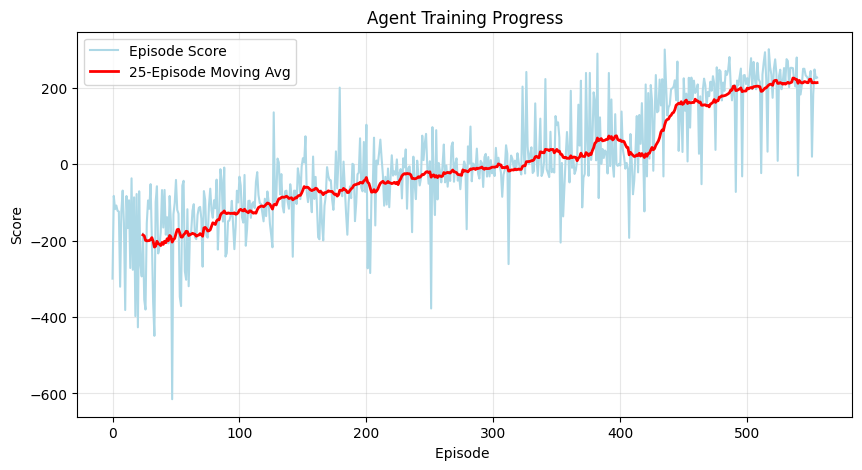

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(all_scores)), all_scores, label='Episode Score', color='lightblue')


rolling_mean = pd.Series(all_scores).rolling(window=25).mean()
plt.plot(np.arange(len(all_scores)), rolling_mean, label='25-Episode Moving Avg', color='red', linewidth=2)

plt.ylabel('Score')
plt.xlabel('Episode ')
plt.title('Agent Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
